In [1]:
import numpy as np
from maelstrom import Maelstrom
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 300

In [2]:
t, y = np.loadtxt('data/kic9651065_lc.txt', usecols=(0,1)).T

In [3]:
ms = Maelstrom(t, y, max_peaks=5, fmin=10, fmax=48)
#ax = ms.plot_time_delay_periodogram(segment_size=5.5, annotate=False, max_period=300)

In [4]:
%run paper/notebooks/setup.py

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24f368d0>,
      dtype=object)

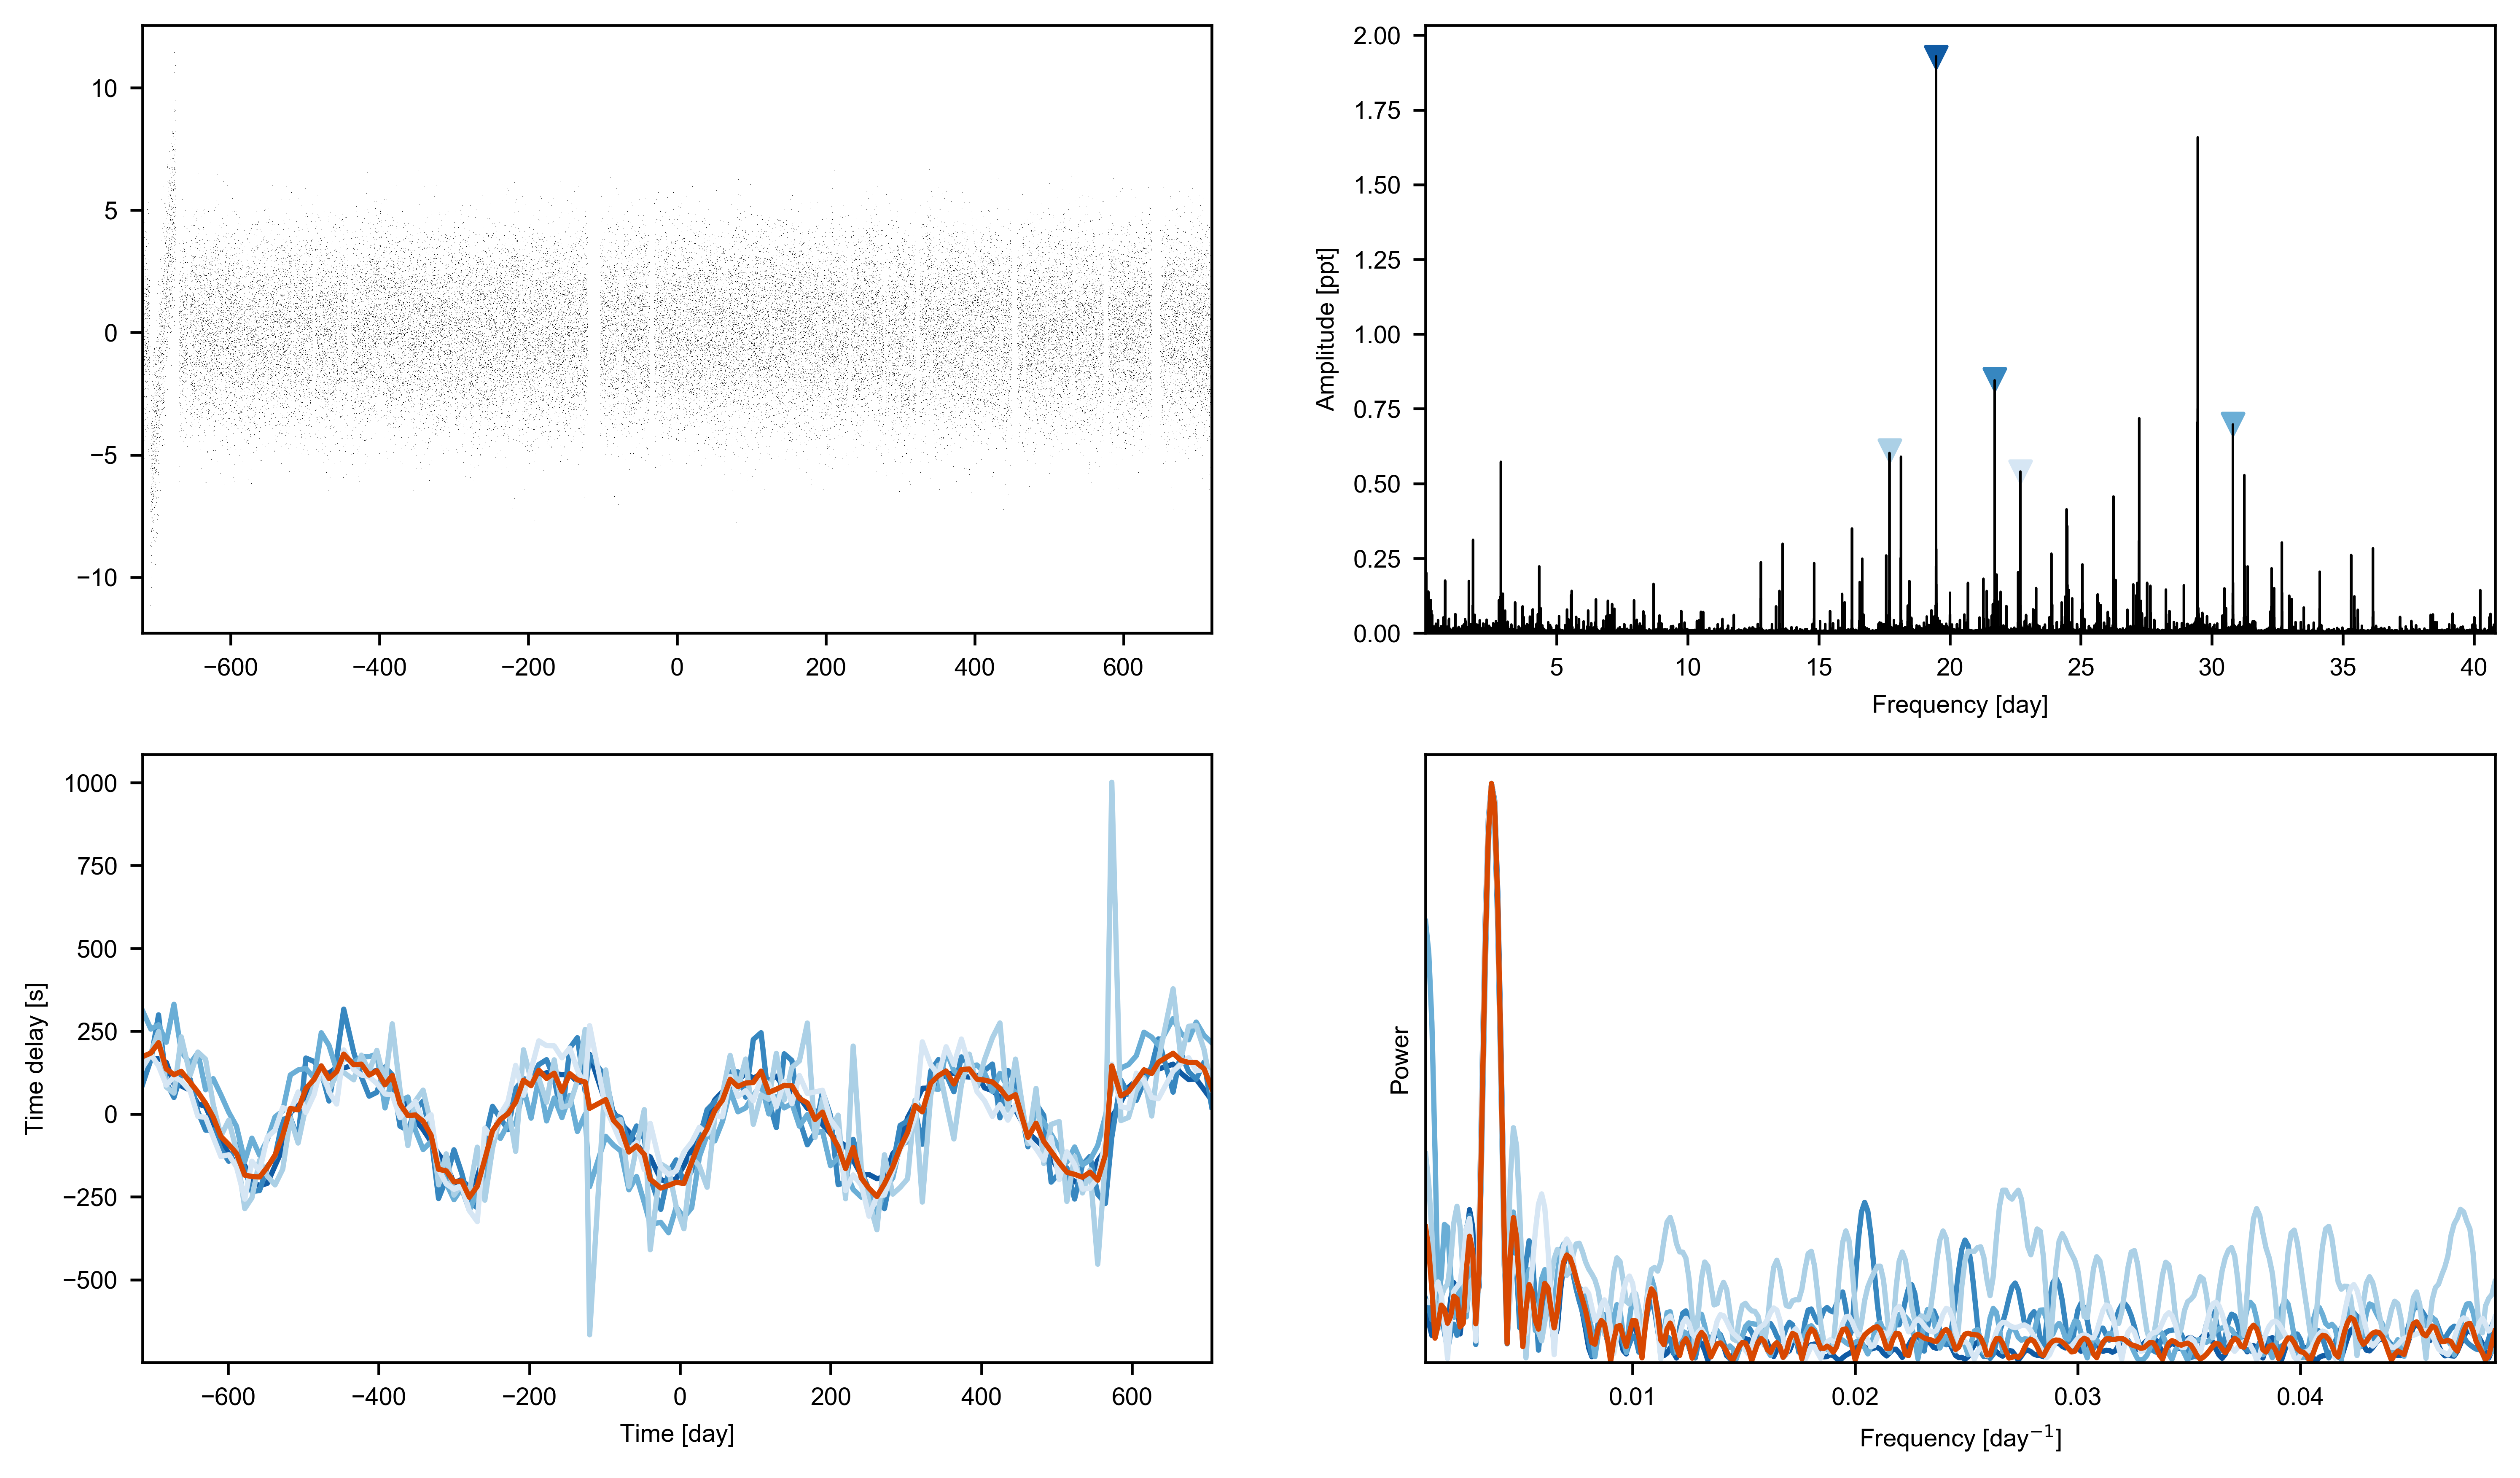

In [5]:
ms.first_look()

In [14]:
pg = ms.period_search()

In [15]:
periods = np.linspace(2, 15, 50)

results = pg.fit(periods)

100%|██████████| 50/50 [01:20<00:00,  1.56s/it]


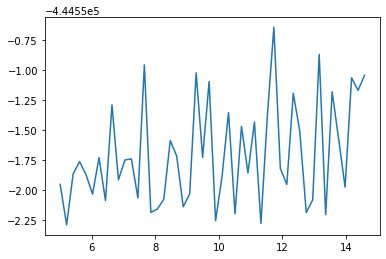

In [53]:
ys = np.array([[r[0] for r in row] for row in results])
#sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], ys[0][:-2]);

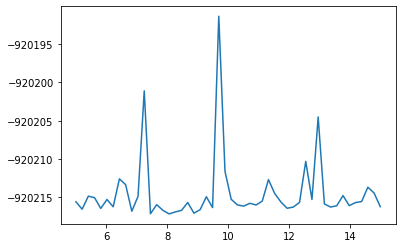

In [49]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods, sm);

In [6]:
time, mag = ms.time, ms.flux
freq = ms.freq

In [14]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(10),
                    upper=np.log(1000))("logP", mu=np.log(272), sd=1.0,
                                      testval=np.log(272))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(1000))('logasini', mu=np.log(184), sd=1,
                                            testval=np.log(184))
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-1.03171101)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.05))("logw0", mu=np.log(2*np.pi/0.1), sd=10,
                                                testval=np.log(2*np.pi/0.1))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())

    trace = pm.load_trace(directory='traces/9651065/')

In [9]:
import theano

with model:
    func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
#     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    args = xo.utils.get_args_for_theano_function(model.test_point)
    print(func(*args))
    
    %timeit func(*args)

-281817.8010946567
26.5 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
func.profile.summary()

Function profiling
  Message: /Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:35
  Time in 82 calls to Function.__call__: 2.235522e+00s
  Time in Function.fn.__call__: 2.228914e+00s (99.704%)
  Time in thunks: 2.212290e+00s (98.961%)
  Total compile time: 1.206813e+00s
    Number of Apply nodes: 131
    Theano Optimizer time: 1.032108e+00s
       Theano validate time: 2.556205e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 9.918690e-02s
       Import time 1.388097e-02s
       Node make_thunk time 9.467196e-02s
           Node Elemwise{Composite{Switch(EQ(i0, i1), (i2 + (i3 * i4)), i5)}}[(0, 4)](FactorOp{J=2, n_rhs=-1}.3, TensorConstant{0}, TensorConstant{-58837.796404028784}, TensorConstant{-0.5}, Sum{acc_dtype=float64}.0, TensorConstant{-inf}) time 1.499391e-02s
           Node Elemwise{Composite{(i0 * sin((((i1 * i2 * i3) - (i4 * i2 * i5 * i6 * i7)) - i8)))}}(Elemwise{Exp}[(0, 0)].0, TensorConstant{(1, 1) of ..5307179586}, Elemwise

[phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -292404.0058539292 -> -292403.6747009486
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -292403.6747009486 -> -154500.72631008748
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Desired error not necessarily achieved due to precision loss.
logp: -154500.72631008748 -> -153286.8127821818
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -153286.8127821818 -> -128544.9989776278
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -128544.9989776278 -> -128523.89614212098
optimizing logp for variables: ['phi_a

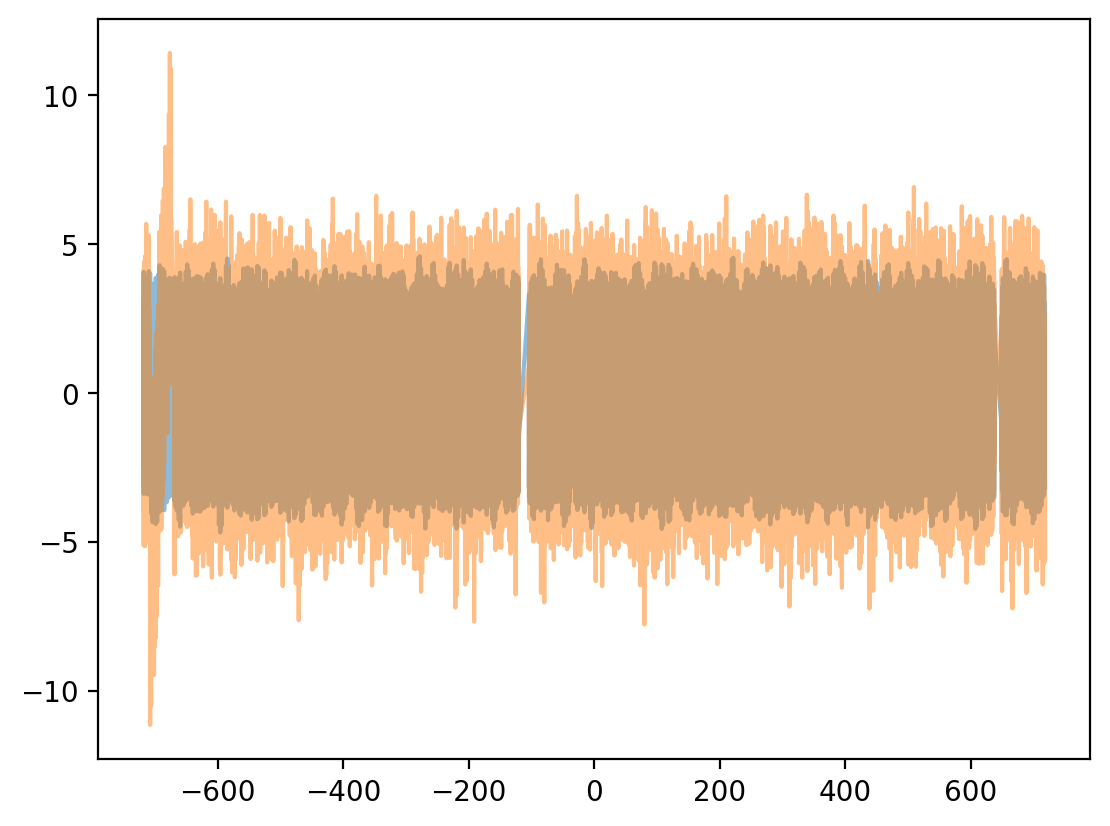

In [15]:
"""
with model:
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[w])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logw0, logpower])

    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)"""

with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

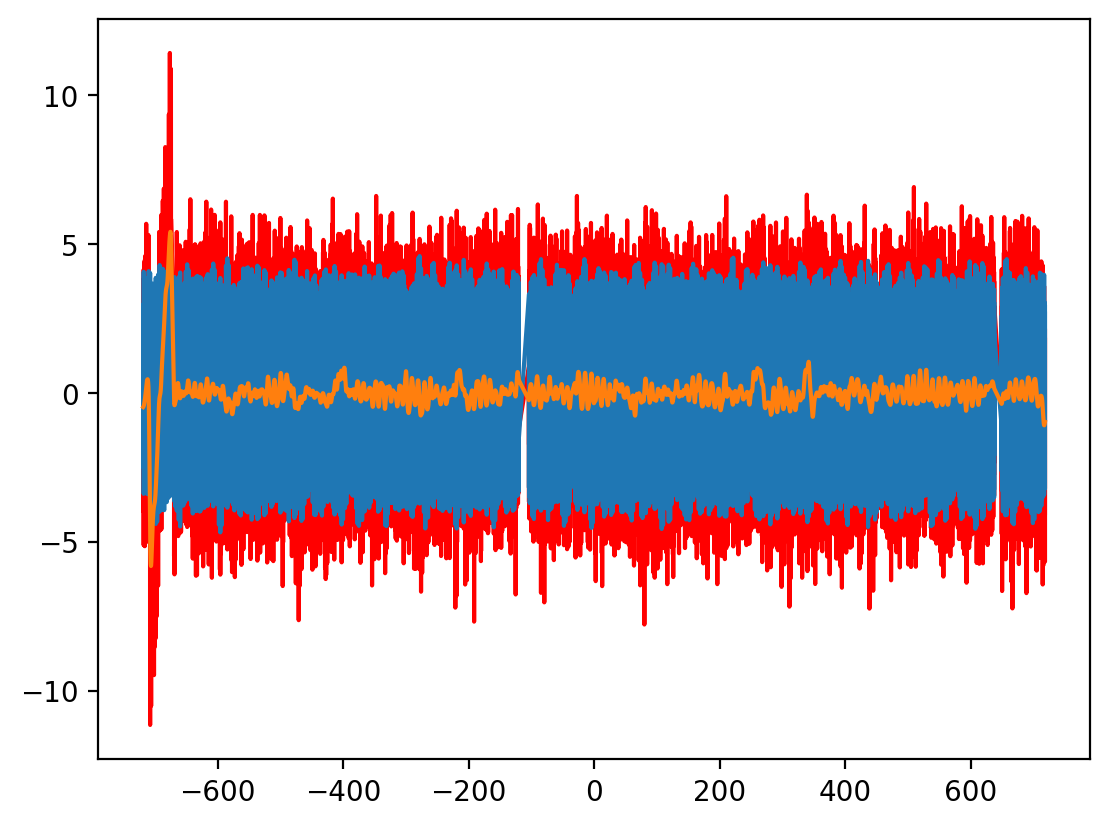

In [10]:
with model:
    plt.plot(time, mag, c='r')
    plt.plot(time, xo.eval_in_model(full_lc, map_params))
    plt.plot(time, xo.eval_in_model(gp.predict(), map_params))
    #plt.xlim(56200, 56210)

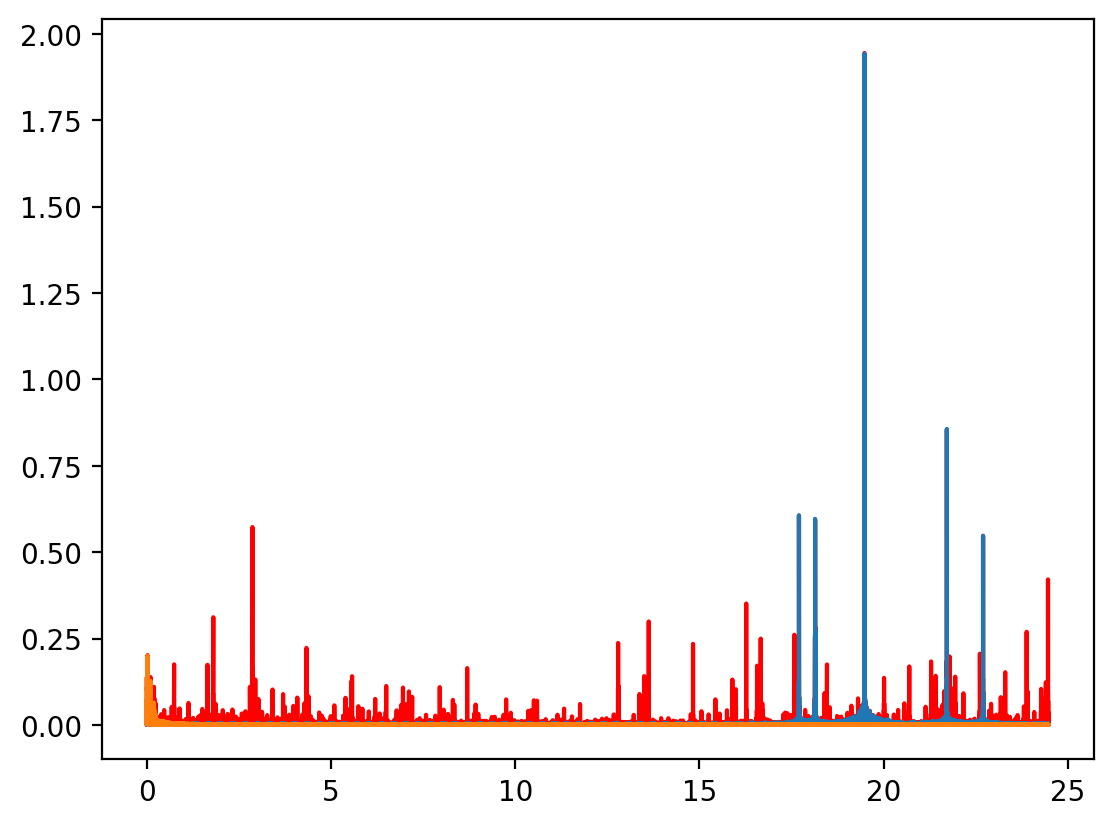

In [16]:
from maelstrom.utils import amplitude_spectrum

with model:
    plt.plot(*amplitude_spectrum(time, mag), c='r')
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)))
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)))
    #plt.xlim(56200, 56210)

In [31]:
ms.freq

array([19.47767425, 21.71213381, 30.80189743, 17.69941557, 22.69429365])

In [35]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

INFO (theano.gof.compilelock): Refreshing lock /Users/danielhey/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
Sampling 2 chains: 100%|██████████| 1004/1004 [07:32<00:00,  1.18draws/s]


In [36]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logpower, logw0, logamp, phase, lognu, mean, eccen, omega, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [26:43<00:00,  1.25draws/s]


In [97]:
np.quantile(trace['period'], [0.025])

array([271.35864274])

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,0.119018,2.854770e-03,3.945077e-05,0.113179,0.124327,5675.576405,0.999763
mean,0.002968,4.599912e-02,6.051336e-04,-0.082057,0.098946,5863.030364,1.000000
lognu__0,2.969269,6.463291e-08,7.574460e-10,2.969269,2.969269,6978.940913,1.000076
lognu__1,3.077871,1.281341e-07,1.566529e-09,3.077871,3.077872,6462.613690,1.000585
lognu__2,3.427576,1.112597e-07,1.363765e-09,3.427576,3.427577,5328.709528,0.999751
lognu__3,2.873532,2.218326e-07,2.935050e-09,2.873531,2.873532,6191.568273,0.999884
lognu__4,3.122114,1.932299e-07,2.627160e-09,3.122113,3.122114,6251.265930,0.999838
logpower,-3.063191,8.938518e-02,1.124072e-03,-3.244920,-2.894593,6939.624649,0.999758
logP,5.606219,1.402931e-03,1.771519e-05,5.603362,5.608826,6306.653153,0.999750
period,272.113645,3.817509e-01,4.819639e-03,271.337112,272.823888,6306.923455,0.999750


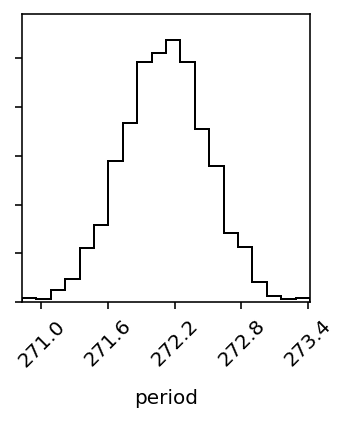

In [57]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=['period']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples);

In [13]:
from maelstrom.utils import mass_function
import astropy.units as u
mf = mass_function(trace['period'] * u.day, trace['asini'] * u.s)

In [18]:
2.199 - np.pi

-0.9425926535897933

In [17]:
np.mean(mf)

<Quantity 0.09065075 solMass>

In [24]:
samples.columns

Index(['period', 'asini', 'eccen', 'omega', 'phi'], dtype='object')

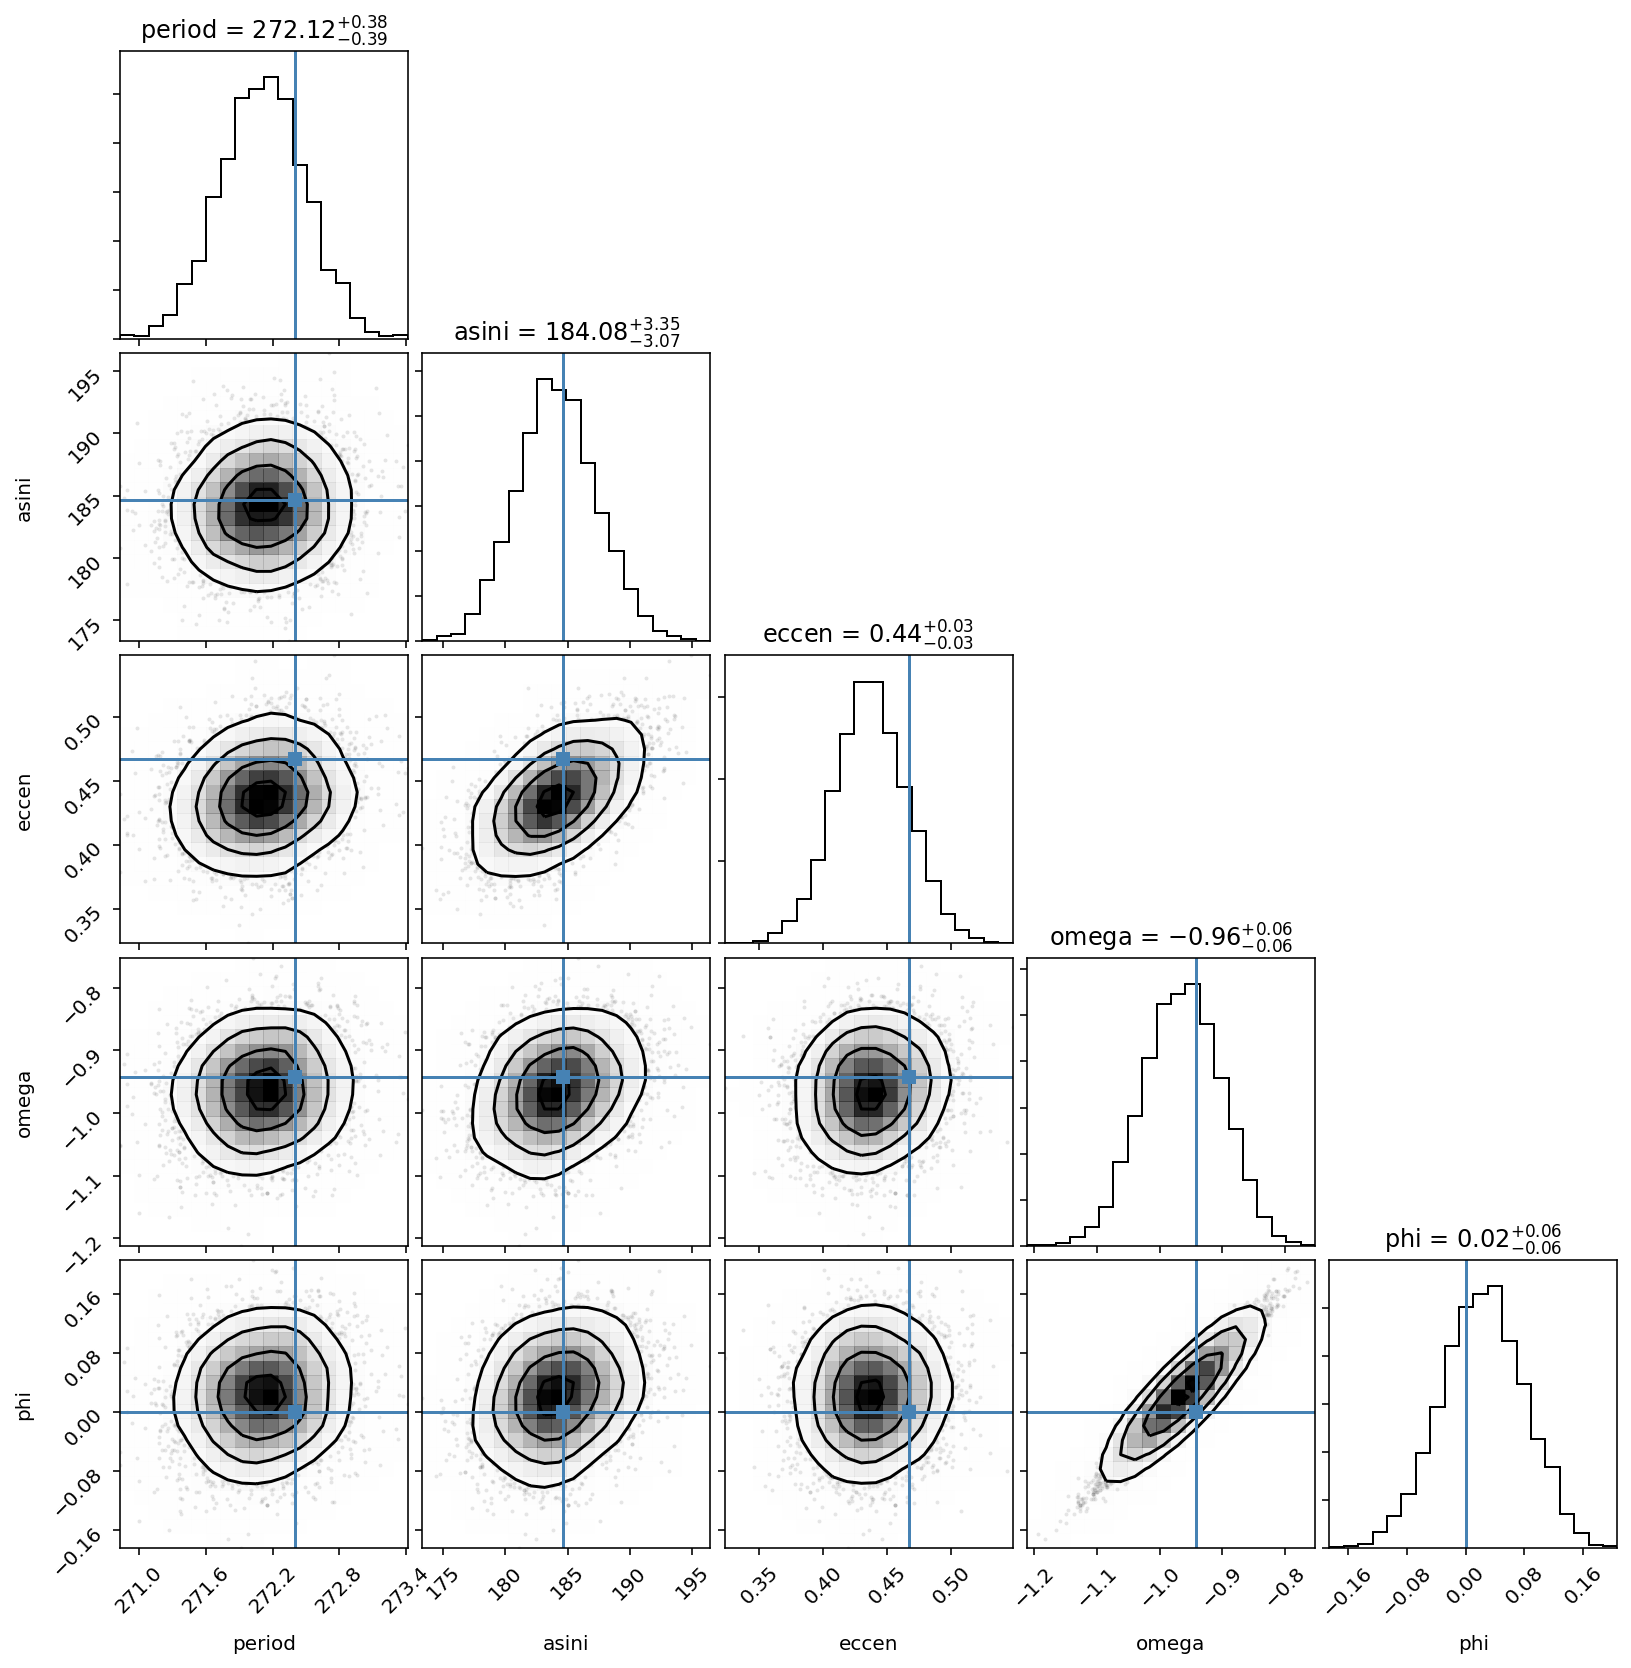

In [23]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'eccen', 'omega', 'phi'])
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
corner.corner(samples, smooth=1, bins=20, truths=[272.4, 184.6, 0.4670, -0.942592653589793, 0.],
             show_titles=True);

In [25]:
corner.corner?

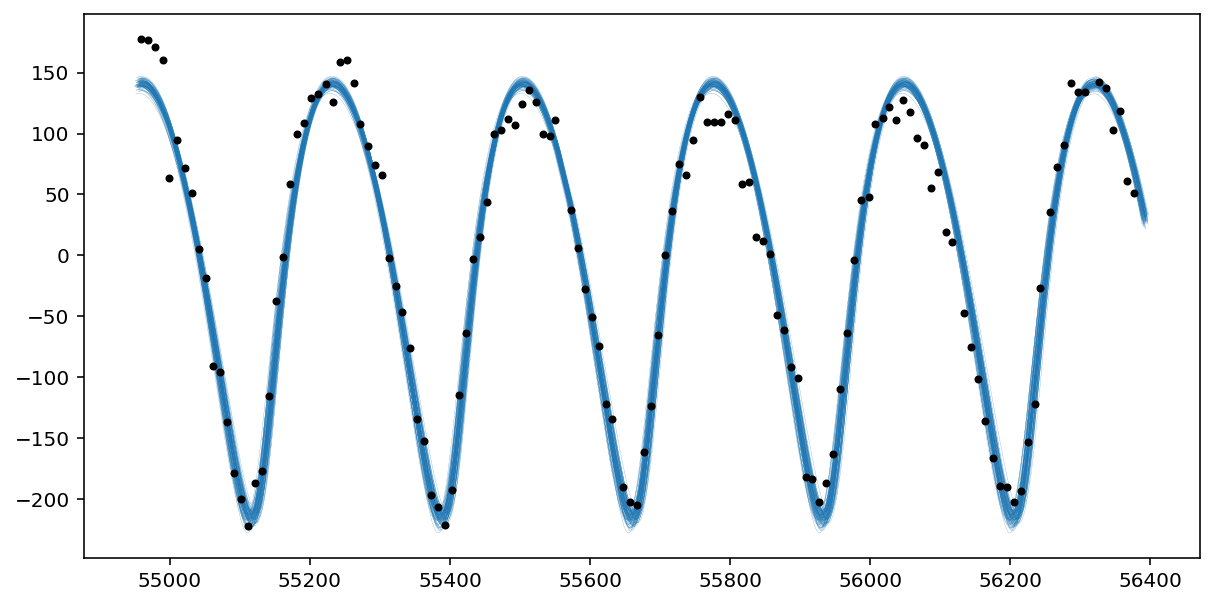

In [77]:
fig, ax = plt.subplots(figsize=[10,5])
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        taumod = xo.eval_in_model(asini * psi, samp)
        ax.plot(ms.time_mid + time + xo.eval_in_model(phi * period / (2*np.pi), samp), taumod - np.mean(taumod), color="C0", linewidth=0.1)
        
a, b = ms.get_time_delay(segment_size=10)
ax.plot(a + ms.time_mid, b[:,0], '.k')
#plt.xlim(0, 50)

In [90]:
pm.save_trace(trace, directory='traces/9651065/')

'traces/9651065/'

In [78]:
with model:
    lc_lc = []
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        lc_lc.append(xo.eval_in_model(lc_model + gp.predict(), samp))

(55200, 55201)

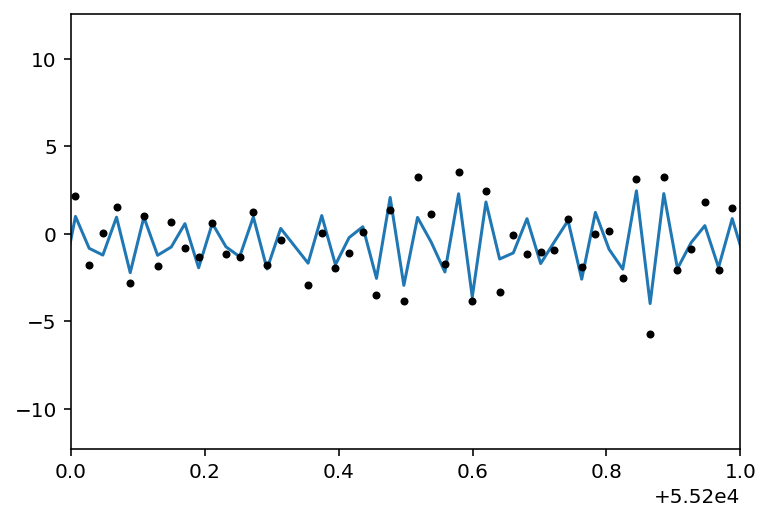

In [86]:
plt.plot(time + ms.time_mid, np.mean(lc_lc, axis=0))
plt.plot(time + ms.time_mid, mag, '.k')
plt.xlim(55200, 55201)

(-5, 5)

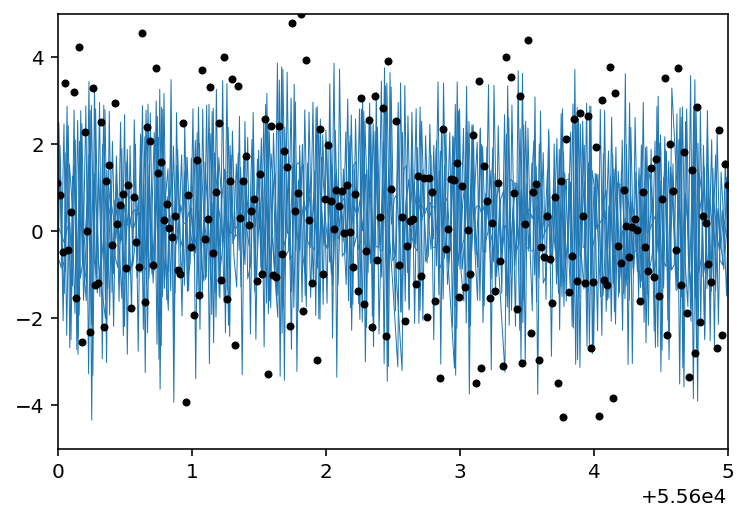

In [87]:
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=5):
        plt.plot(ms.time_mid + time + xo.eval_in_model(phi * period / (2*np.pi), samp), 
                 xo.eval_in_model(lc_model + gp.predict(), samp), color="C0", linewidth=0.5)
plt.plot(time + ms.time_mid, mag, '.k')
plt.xlim(55600, 55605)
plt.ylim(-5, 5)

In [104]:
trace2 = pm.load_trace?

In [106]:
with pm.Model() as model2:
    trace2 = pm.load_trace(directory='traces/9651065/')

In [109]:
np.mean(trace2['period'])

KeyError: 'Unknown variable period'

In [ ]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
import pymc3 as pm

time_tensor = theano.shared(time)
flux_tensor = theano.shared(mag)

with pm.Model() as model:
    # Period
    logP = pm.Normal("logP", mu=np.log(272.), sd=1., shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    drift = pm.Normal('drift_grad', mu=0.0, sd=0.01)
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(0.0001*np.median(np.abs(np.diff(mag)))), sd=10, testval=0.)
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(170)) 
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform('eccen', lower=1e-4, upper=0.99, testval=0.5)
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
   
    # Mean anom
    M = 2.0 * np.pi * time_tensor / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + tt.zeros_like(M))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    factor = 2. * np.pi * freq
    arg = (factor * (1 - drift)) * time_tensor[:, None]
    arg -= (factor * (tt.exp(logasini)) / 86400) * psi[:, None]
    
    sinarg = tt.sin(arg)
    cosarg = tt.cos(arg)
        
    #DT = tt.concatenate((sinarg, cosarg), axis=-1).T
    #D = DT.T
    # Singular matrix ?
    DT = tt.concatenate((sinarg, cosarg), axis=-1).T
    
    w = pm.Normal("w", mu=0.0, sd=100.0, shape=len(freq)*2,
                  testval=np.random.randn(len(freq)*2))
    
    D = DT.T
#     w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux_tensor - mean))
#     pm.Deterministic('w', w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(D, w)
    
    # Jitter & GP parameters
    #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1000)
    
    #logw0 = BoundedNormal("logw0", mu=np.log(2*np.pi/10), sd=1)
    #logpower = BoundedNormal("logpower", mu=np.log(np.var(mag)), sd=1)
    
    logw0_guess = np.log(2*np.pi/1.)
    logw0 = pm.Normal("logw0", mu=logw0_guess, sd=100)
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)) + 4*logw0_guess, sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))    
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    
    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
    #pm.Deterministic("gp_pred", gp.predict())

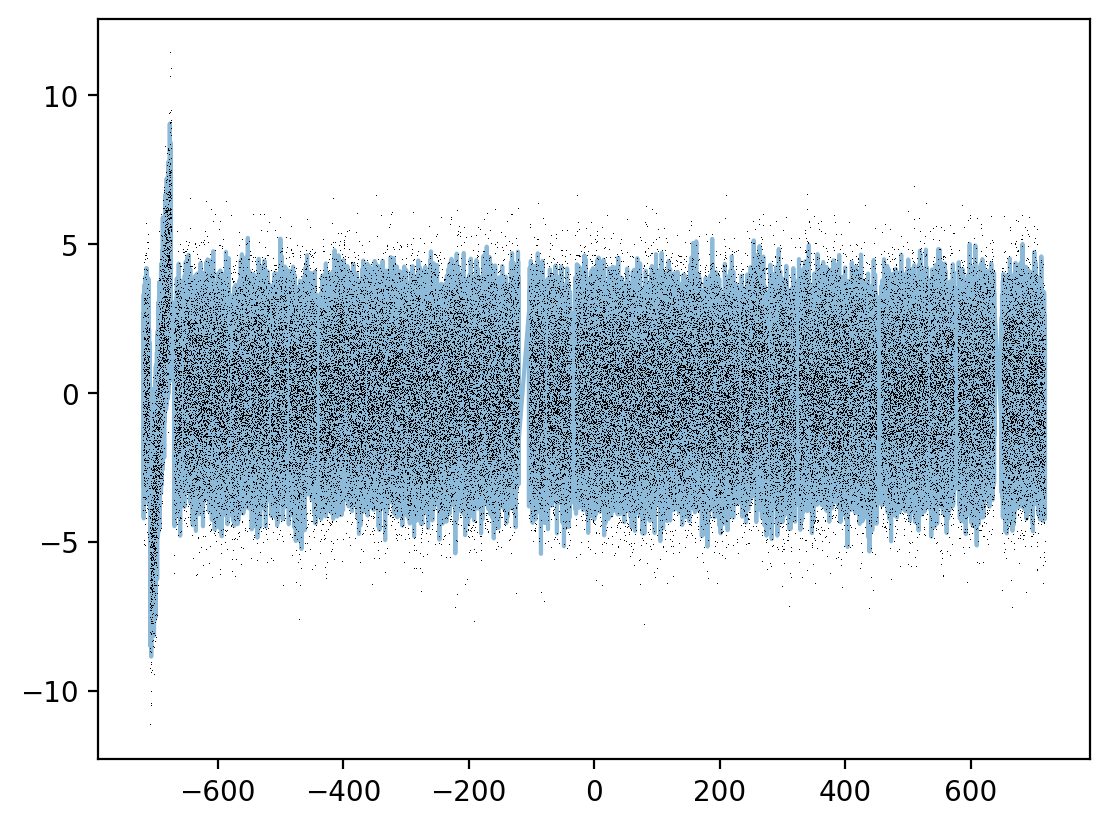

In [17]:
with model:
    plt.plot(time, xo.eval_in_model(lc_model, map_params) + xo.eval_in_model(gp.predict(), map_params), alpha=0.5)
    plt.plot(time, mag, ',k')
    #plt.xlim(56000, 56010)

In [18]:
map_params

{'logP': array([5.60626369]),
 'drift_grad': array(-1.73681919e-07),
 'phi_angle__': array([0.10748012, 4.47084414]),
 'logs_lc': array(0.04389495),
 'logasini_interval__': array(1.1259702),
 'omega_angle__': array([-3.67145935,  2.55350457]),
 'eccen_interval__': array(-0.23291331),
 'mean': array(-0.0008661),
 'w': array([-1.07931396, -0.86476185, -0.48638043,  0.61849194, -0.50602899,
         1.62981074,  0.07136973, -0.5439016 , -0.01951816, -0.2225052 ]),
 'logw0': array(2.52940024),
 'logpower': array(7.4010915),
 'period': array([272.12558987]),
 'phi': array(0.0240356),
 'logasini': array(5.21600766),
 'asini': array(184.19733583),
 'omega': array(-0.96309604),
 'eccen': array(0.43766895),
 'phase': array(-2.46611168),
 'logS0': array(-2.71650947)}

In [153]:
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all(quality_bitmask="hardest")
    
    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())
    lc = lc.remove_outliers()

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, magnitude

# time, mag = get_lightcurve('KIC 6780873', cadence='long')
# time, mag = get_lightcurve('KIC 9651065', cadence='long')
time, mag = get_lightcurve('KIC 10080943', cadence='long')
#time, mag = get_lightcurve('KIC 5768203', cadence='long')



# time = time[:5000]
# mag = mag[:5000]
# time = time[:-1000]
# mag = mag[:-1000]
# time = time[1000:8000]
# mag = mag[1000:8000]
time -= np.mean(time)
mag *= 1000

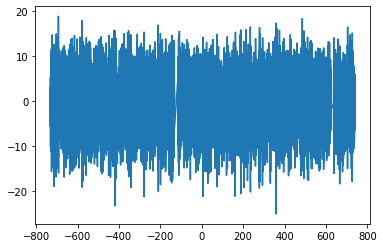

In [154]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
import pymc3 as pm

plt.plot(time, mag)

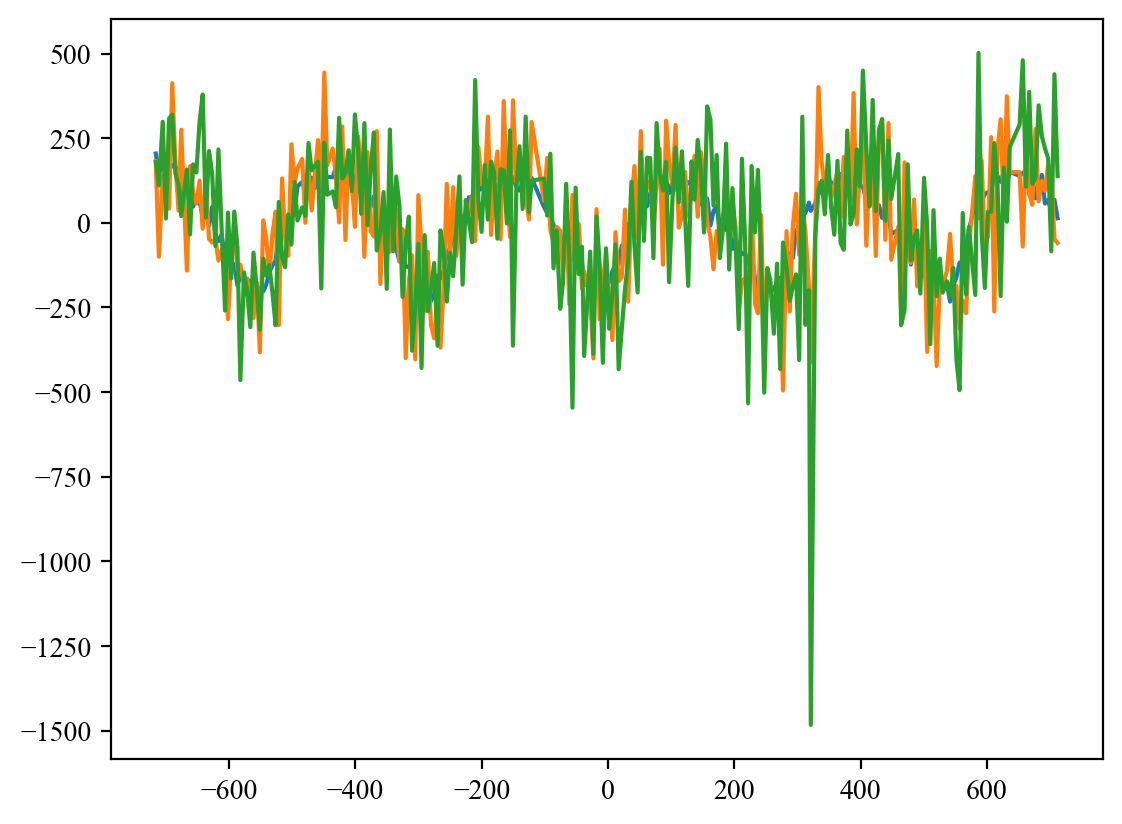

In [44]:
from maelstrom import Maelstrom

ms = Maelstrom(time, mag / 1e3, fmin=5, max_peaks=3)

a, b = ms.get_time_delay(segment_size=5)
plt.plot(a, b)

100%|██████████| 294/294 [00:00<00:00, 2790.91it/s]


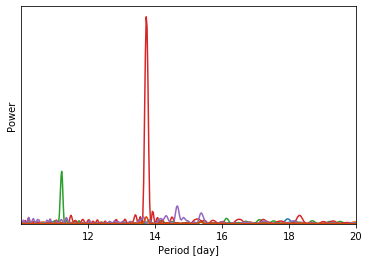

In [162]:
ms.plot_time_delay_periodogram(segment_size=5, annotate=False, min_period=10, max_period=20)

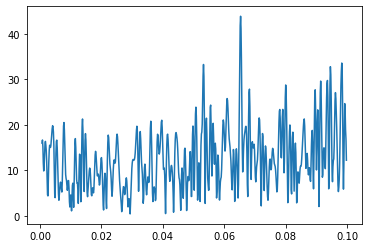

In [157]:
tt = np.array(b[0])
plt.plot(*amplitude_spectrum(np.array(a), tt))

In [158]:
1/15.33

0.06523157208088715

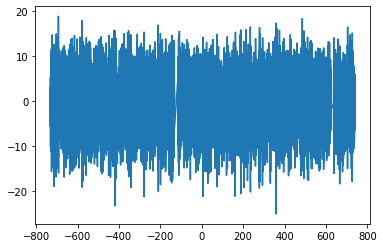

In [159]:
plt.plot(time, mag)

In [152]:
freq = ms.freq
import tqdm
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
import pymc3 as pm

with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(20), 50))
periods = np.linspace(5, 20, 100)
results = []
for f in freq:
    results.append([run_fit(p, f) for p in tqdm.tqdm(periods)])

100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


In [170]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [171]:
freq = ms.freq
import tqdm
t0s = np.arange(time.min(), time.max(), 5.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm.tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], mag[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 267/267 [00:00<00:00, 3921.39it/s]


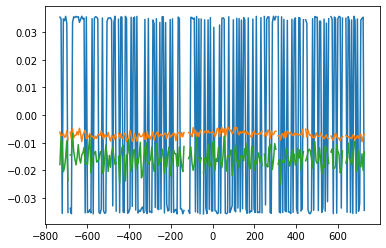

In [172]:
plt.plot(t0s[:-1], phases)

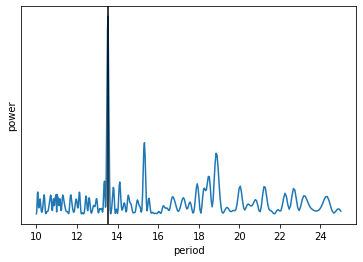

In [173]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], phases[m, 0], min_period=10, max_period=25)
f, p = res["periodogram"]
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")
plt.yticks([]);

In [174]:
ms.freq

array([13.94758936, 15.68332657, 12.45258064])

In [168]:
period_guess = res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess

(13.535459980056611, 1363.989261361565)

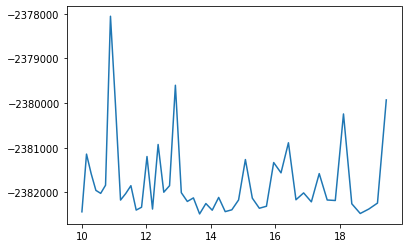

In [20]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

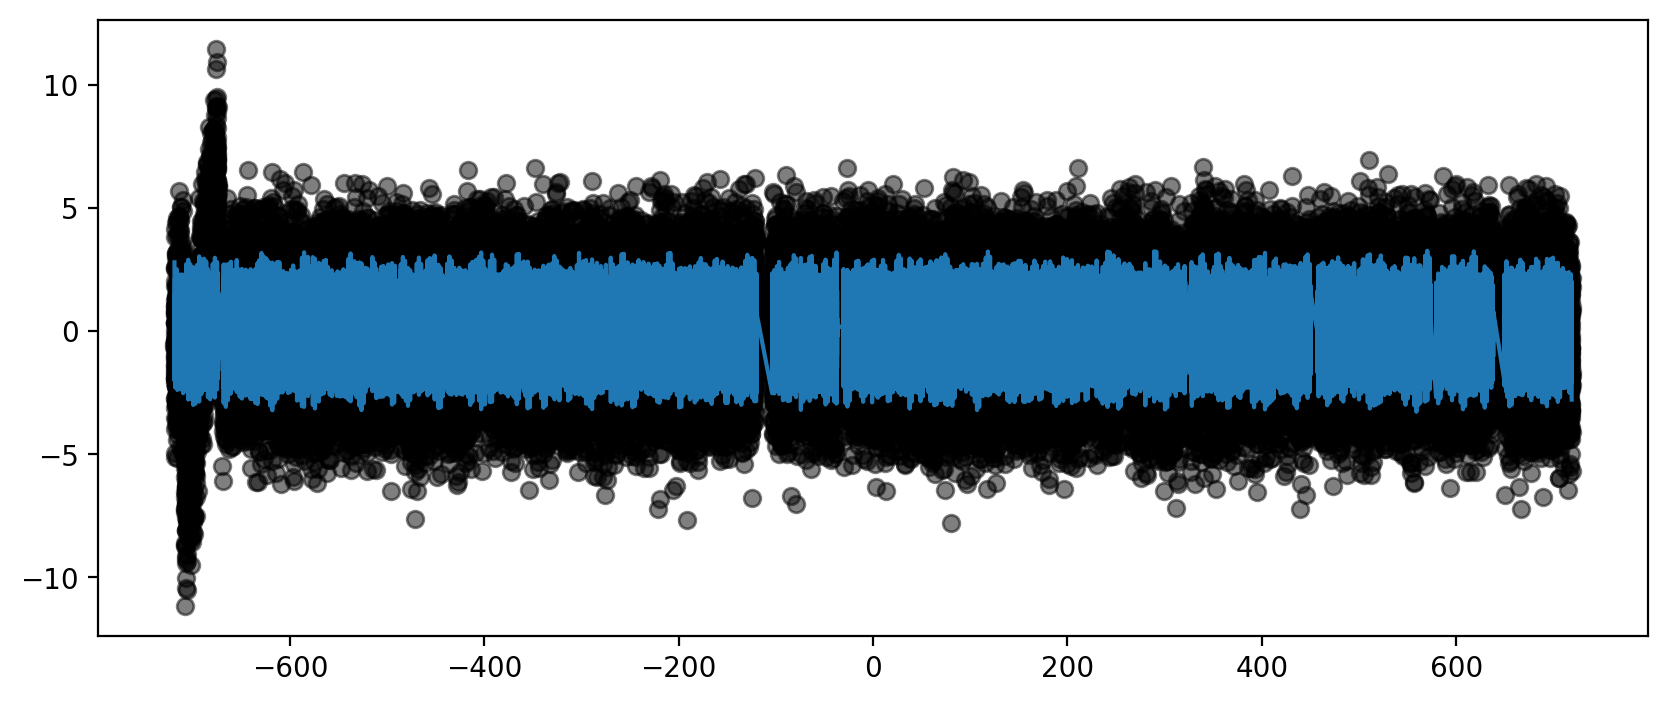

In [19]:
with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(10),
                    upper=np.log(50))("logP", mu=np.log(272.), sd=1.0)
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=-7.78585661)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(1000))('logasini', mu=np.log(170), sd=10)
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/2.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())


    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,mag, c='black', alpha=0.5)

[phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -80307943398.41592 -> -80307943296.31284
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -80307943296.31284 -> -154124.26907127982
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Optimization terminated successfully.
logp: -154124.26907127982 -> -152733.1095281013
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -152733.1095281013 -> -127657.06803938905
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -127657.06803938905 -> -127555.8711061974
optimizing logp for variables: ['phi_angle__']
message: Optim

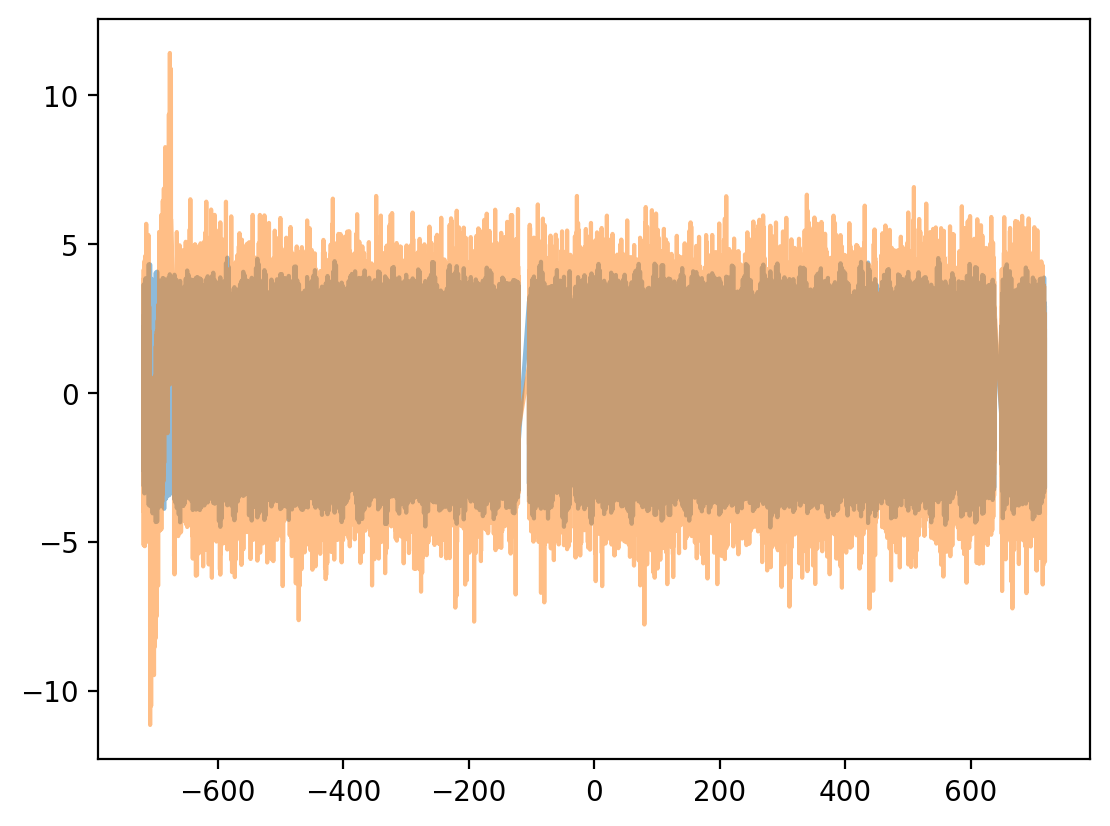

In [20]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [21]:
map_params

{'logP_interval__': array(-0.03310846),
 'phi_angle__': array([ 2.96938921, -3.34406078]),
 'logs_lc': array(0.15696795),
 'logasini_interval__': array(-2.33565678),
 'omega_angle__': array([0.64512758, 4.42536011]),
 'eccen_interval__': array(2.17409391),
 'mean': array(0.00294435),
 'lognu': array([2.96926889, 3.07787126, 3.42757628, 2.87353162, 3.12211351]),
 'phase_angle__': array([[-4.05711888, -1.10996366,  2.52809351,  0.82743613,  1.04693692],
        [-1.88143265, -4.33220265, -3.68900129,  4.3949246 , -4.34786412]]),
 'logamp_interval__': array([ 3.05117065,  0.40353166,  0.0577587 , -0.18281495, -0.38771579]),
 'logw0_interval__': array(-0.0568445),
 'logpower': array(-3.11077319),
 'logP': array(3.09398377),
 'period': array(22.06480412),
 'phi': array(2.41546995),
 'logasini': array(2.70881923),
 'asini': array(15.0115398),
 'omega': array(0.14475996),
 'eccen': array(0.808109),
 'nu': array([19.47767415, 21.71213378, 30.80189704, 17.6994155 , 22.69429354]),
 'phase': arra

Text(0.5, 1.0, 'The quick brown fox')

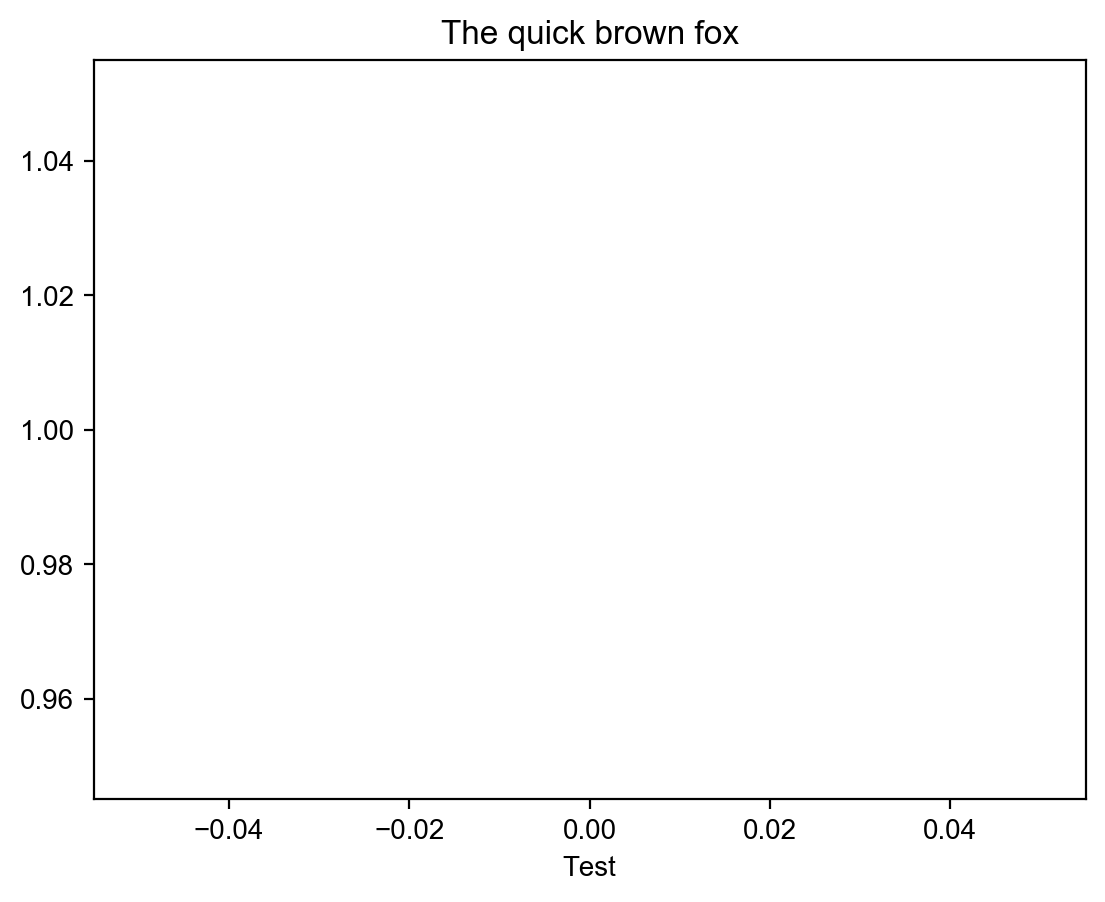

In [38]:
plt.rcParams['font.family'] = 'Arial'
plt.plot(0,1)
plt.xlabel('Test')
plt.title('The quick brown fox')

Text(0.5, 1.0, 'The quick brown fox')

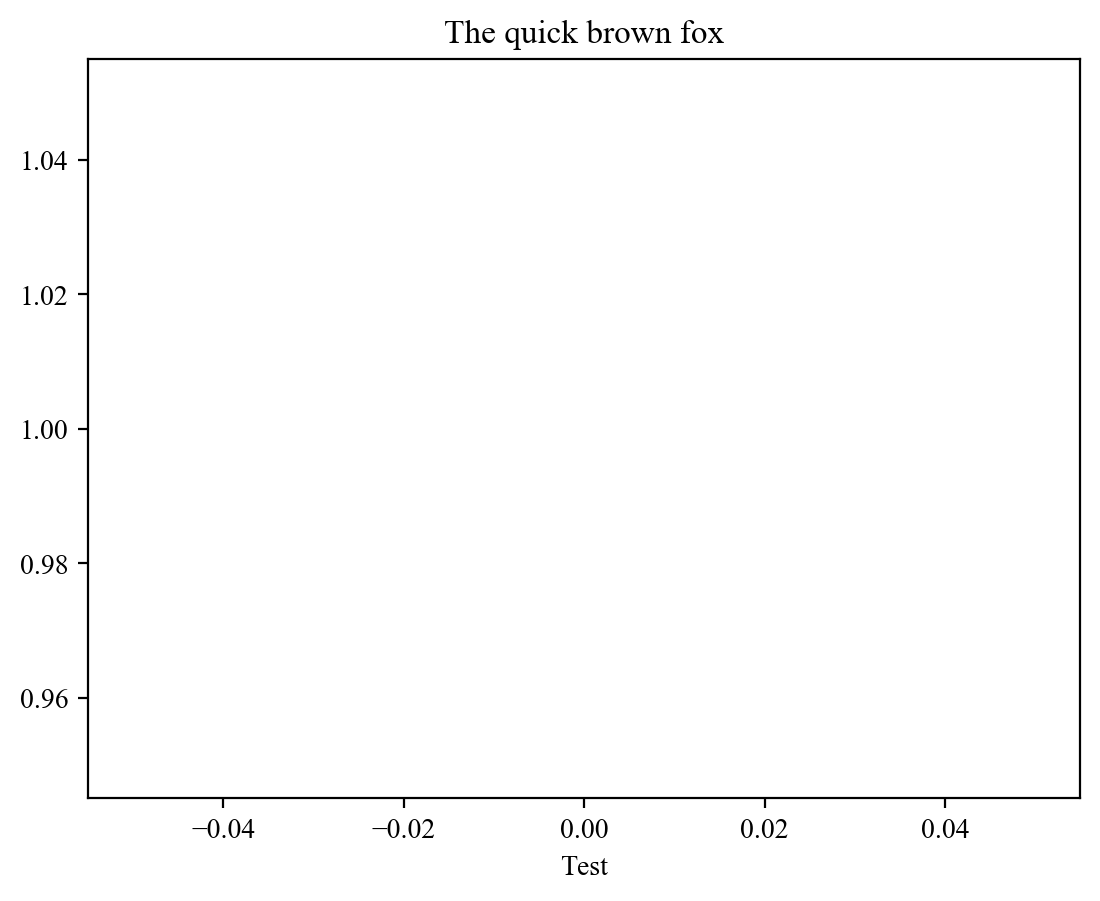

In [42]:
#plt.rcParams['font.family'] = 'Arial'
plt.rc('font', family='serif')
plt.plot(0,1)
plt.xlabel('Test')
plt.title('The quick brown fox')

In [22]:
plt.rcParams['font.family']

['Computer Modern Roman']

In [176]:
from maelstrom.periodogram import Periodogram

In [43]:
plt.rcParams['xtick.labelsize'] = 'medium'

#xtick.labelsize : 16
#ytick.labelsize : 16